In [2]:
!pip install tikzplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.2 MB/s eta 0:00:00


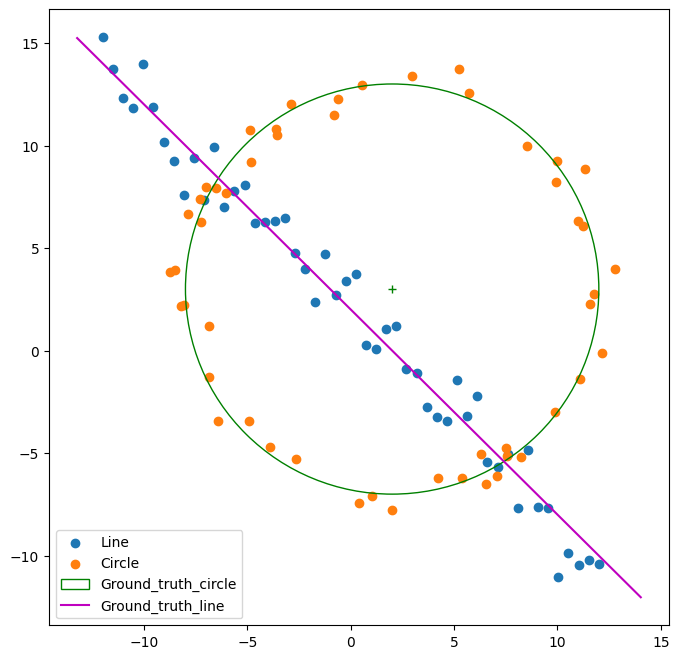

In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

plt.legend()
plt.show()

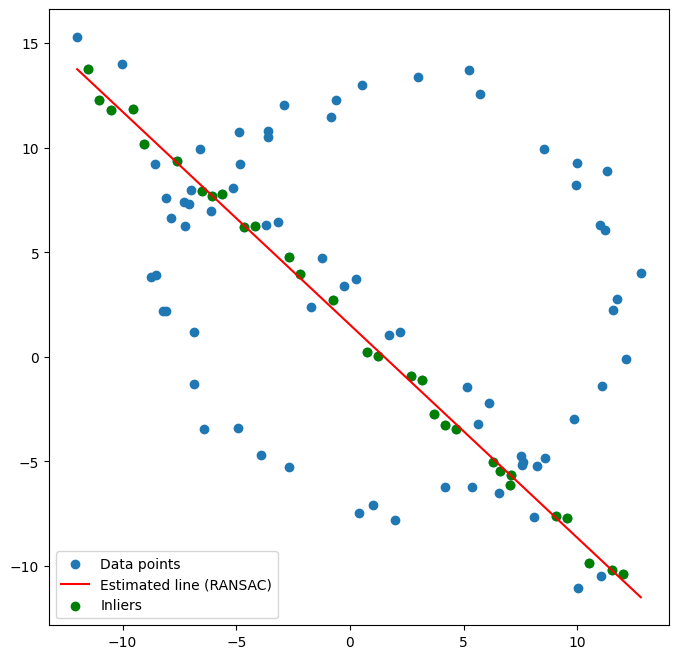

In [5]:
# Helper function to compute distance of points from a line
def compute_line_distance(points, a, b, d):
    return np.abs(a * points[:, 0] + b * points[:, 1] + d) / np.sqrt(a**2 + b**2)

# RANSAC algorithm to estimate a line
def ransac_line(X, threshold, num_iterations):
    best_inliers = []
    best_params = None

    for i in range(num_iterations):
        # Randomly select two points to define the line
        sample = X[np.random.choice(X.shape[0], 2, replace=False), :]

        # Compute line parameters: ax + by + d = 0
        # [a,b] is normal to the line
        p1, p2 = sample[0], sample[1]
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = -(a * p1[0] + b * p1[1])
        norm = np.sqrt(a**2 + b**2)
        a, b, d = a/norm, b/norm, d/norm  # Normalize to satisfy ∥[a,b]⊺∥=1

        # Calculate the distances of all points to the line
        distances = compute_line_distance(X, a, b, d)

        # Identify inliers
        inliers = X[distances < threshold]

        # Keep the model with the most inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_params = (a, b, d)

    return best_params, best_inliers

# Use the provided noisy point set
# Set parameters for RANSAC
ransac_iterations = 100
ransac_threshold = 0.5  # Adjust based on data

# Estimate the line using RANSAC
best_line_params, best_line_inliers = ransac_line(X, ransac_threshold, ransac_iterations)

# Plot the points and the estimated line
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Data points')
a, b, d = best_line_params
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_vals = -(a * x_vals + d) / b
ax.plot(x_vals, y_vals, color='r', label='Estimated line (RANSAC)')
ax.scatter(best_line_inliers[:, 0], best_line_inliers[:, 1], color='g', label='Inliers')
plt.legend()
plt.show()


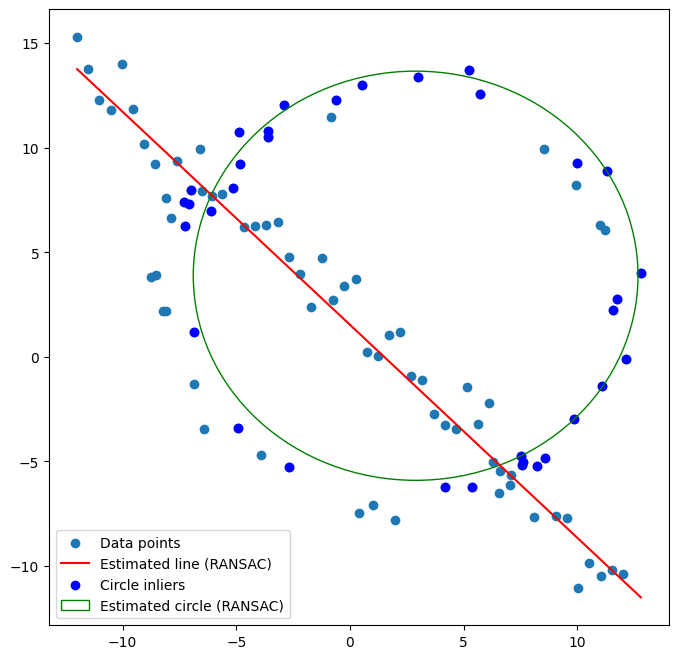

In [6]:
from scipy.optimize import minimize

# Circle fitting error function
def circle_error(params, points):
    xc, yc, r = params
    distances = np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)
    return np.mean((distances - r) ** 2)

# RANSAC algorithm to estimate a circle
def ransac_circle(X, threshold, num_iterations):
    best_inliers = []
    best_params = None

    for i in range(num_iterations):
        # Randomly select three points to define a circle
        sample = X[np.random.choice(X.shape[0], 3, replace=False), :]

        # Fit a circle to the sample points using optimization
        def initial_circle(p1, p2, p3):
            x1, y1 = p1
            x2, y2 = p2
            x3, y3 = p3
            ma = (y2 - y1) / (x2 - x1)
            mb = (y3 - y2) / (x3 - x2)
            xc = (ma * mb * (y3 - y1) + ma * (x2 + x3) - mb * (x1 + x2)) / (2 * (ma - mb))
            yc = (-1 / ma) * (xc - (x1 + x2) / 2) + (y1 + y2) / 2
            r = np.sqrt((xc - x1)**2 + (yc - y1)**2)
            return xc, yc, r

        xc, yc, r = initial_circle(*sample)

        # Optimize circle fit
        res = minimize(circle_error, [xc, yc, r], args=(X,), method='L-BFGS-B')
        xc, yc, r = res.x

        # Compute radial distances from the circle center
        distances = np.sqrt((X[:, 0] - xc) ** 2 + (X[:, 1] - yc) ** 2)

        # Identify inliers
        inliers = X[np.abs(distances - r) < threshold]

        # Keep the model with the most inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_params = (xc, yc, r)

    return best_params, best_inliers

# Remove the line inliers from the point set
X_remnant = np.array([point for point in X if point not in best_line_inliers])

# Set parameters for RANSAC
ransac_circle_iterations = 100
ransac_circle_threshold = 1.0  # Adjust based on data

# Estimate the circle using RANSAC
best_circle_params, best_circle_inliers = ransac_circle(X_remnant, ransac_circle_threshold, ransac_circle_iterations)

# Plot the points and the estimated circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Data points')
a, b, d = best_line_params
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_vals = -(a * x_vals + d) / b
ax.plot(x_vals, y_vals, color='r', label='Estimated line (RANSAC)')
ax.scatter(best_circle_inliers[:, 0], best_circle_inliers[:, 1], color='b', label='Circle inliers')

# Plot the best-fit circle
circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='g', fill=False, label='Estimated circle (RANSAC)')
ax.add_patch(circle)
plt.legend()
plt.show()


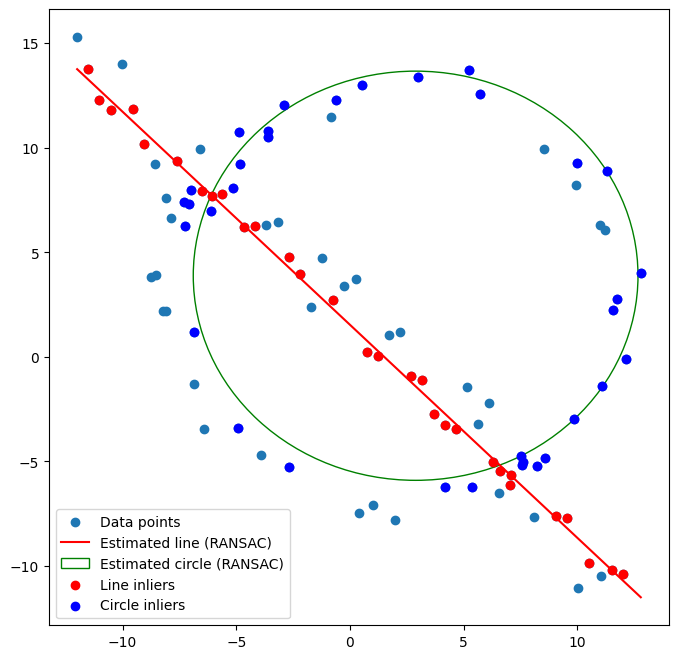

In [7]:
# Combined plot of all results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Data points')

# Plot the line
a, b, d = best_line_params
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_vals = -(a * x_vals + d) / b
ax.plot(x_vals, y_vals, color='r', label='Estimated line (RANSAC)')

# Plot the circle
circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='g', fill=False, label='Estimated circle (RANSAC)')
ax.add_patch(circle)

# Highlight inliers
ax.scatter(best_line_inliers[:, 0], best_line_inliers[:, 1], color='r', label='Line inliers')
ax.scatter(best_circle_inliers[:, 0], best_circle_inliers[:, 1], color='b', label='Circle inliers')

plt.legend()
plt.show()
